### Data Note 1

It is possible for a player to be traded and end up playing in two different games, for two different teams, on the same day.  In other words, (player_id, game_dt) is not sufficient to uniquely identify a record.

Here is a specific example.

In [ ]:
player_game[(player_game['player_id'] == 'morgn001')
          & (player_game['game_dt'] == '2009-05-05')]

### Data Note 2

game_dt and appear_dt have exactly the same information

In [ ]:
# a player always appears on the same date as the game is played
(player_game['game_dt'] == player_game['appear_dt']).all()

In [ ]:
# drop the field with the same values as GAME_DT
player_game.drop('appear_dt', axis=1, inplace=True)

#### Data Note: Frequency of Missing Values by Time Period

Many of the baseball attributes have fewer missing values in more recent data.

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid') # enable seaborn style

In [238]:
def freq_by_years(s, bins, criteria):
    """Frequency of True Values per Year bin"""
    start = s.dt.year.min()
    stop = s.dt.year.max() + 1
    years = np.linspace(start=start, stop=stop, num=bins).astype(np.int)
    
    freq = []
    for i in range(len(years) - 1):
        year = s.dt.year  
        c1 = (years[i] <= year)
        c2 = (year < years[i+1])
        freq.append((c1 & c2 & criteria).sum() / (c1 & c2).sum())
    return pd.Series(data=freq, index=years[1:])        

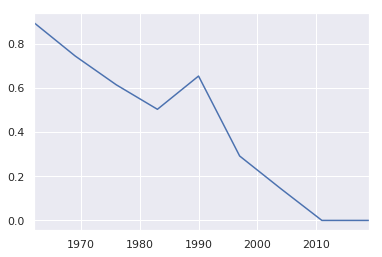

In [239]:
unknown_time = (game['start_game_tm'] == 0)
freq_by_years(game['game_date'], 10, unknown_time).plot();

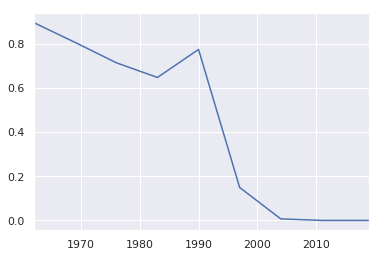

In [240]:
unknown_temp = game['temp_park_ct'].isna()
freq_by_years(game['game_date'], 10, unknown_temp).plot();

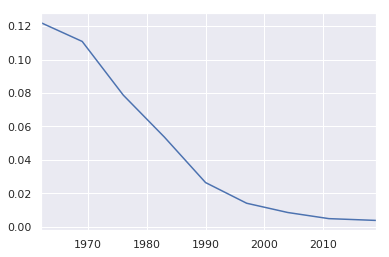

In [241]:
unknown_temp = game['attend_park_ct'].isna()
freq_by_years(game['game_date'], 10, unknown_temp).plot();

### (Partial) Validation the AM/PM Code

The second game of a double header always starts after the first game.  As long as both start times are known, then this can be used to check the am/pm code.

In [212]:
# double headers have game_ct = 1, or game_ct = 2
double_headers = game[game['game_ct'] != 0]

In [213]:
# groupby will keep the sort order the same
double_headers = double_headers.sort_values(['game_date']) # the new datetime field

In [214]:
# except in rare situations, the home team is the same for both games
# and both games are played on the same date
grouped = double_headers.groupby(['home_team_id', 'game_dt'])

In [215]:
# given the custom logic, it is easiest to iterate over the groups
count = 0
for name, df in grouped:
    
    # ignore double headers with different home teams
    if df.shape[0] != 2:
        continue
        
    # can't compare unknown times
    if (df['start_game_tm'] == 0).any():
        continue
        
    # count how many double headers meet the above criteria
    count += 1
    
    # games were sorted by time, so game_ct should be 1,2
    if not (df['game_ct'] == (1,2)).all():
        display(df)
        
print(count)

,game_id,game_dt,game_ct,game_dy,start_game_tm,dh_fl,daynight_park_cd,away_team_id,home_team_id,park_id,...,home_hits_ct,away_err_ct,home_err_ct,away_lob_ct,home_lob_ct,win_pit_id,lose_pit_id,save_pit_id,gwrbi_bat_id,game_date
23,BAL195806062,19580606,2,Friday,154,F,N,KC1,BAL,BAL11,...,7,0,0,2,3,pappm101,herbr101,,,1958-06-06 13:54:00
22,BAL195806061,19580606,1,Friday,537,F,N,KC1,BAL,BAL11,...,8,0,0,4,5,johnc103,kella103,,,1958-06-06 17:37:00


,game_id,game_dt,game_ct,game_dy,start_game_tm,dh_fl,daynight_park_cd,away_team_id,home_team_id,park_id,...,home_hits_ct,away_err_ct,home_err_ct,away_lob_ct,home_lob_ct,win_pit_id,lose_pit_id,save_pit_id,gwrbi_bat_id,game_date
84,BAL197804162,19780416,2,Sunday,239,T,D,MIL,BAL,BAL11,...,8,0,2,10,7,repla101,mcgrs001,rodre102,,1978-04-16 14:39:00
83,BAL197804161,19780416,1,Sunday,245,T,D,MIL,BAL,BAL11,...,12,1,1,8,6,briln101,haasm001,stand101,,1978-04-16 14:45:00


,game_id,game_dt,game_ct,game_dy,start_game_tm,dh_fl,daynight_park_cd,away_team_id,home_team_id,park_id,...,home_hits_ct,away_err_ct,home_err_ct,away_lob_ct,home_lob_ct,win_pit_id,lose_pit_id,save_pit_id,gwrbi_bat_id,game_date
502,CIN196606052,19660605,2,Sunday,100,F,D,CHN,CIN,CIN07,...,12,0,1,7,9,hendb101,mccob105,jenkf101,,1966-06-05 13:00:00
501,CIN196606051,19660605,1,Sunday,100,F,D,CHN,CIN,CIN07,...,13,1,1,9,9,maloj102,handb101,mccob105,,1966-06-05 13:00:00


,game_id,game_dt,game_ct,game_dy,start_game_tm,dh_fl,daynight_park_cd,away_team_id,home_team_id,park_id,...,home_hits_ct,away_err_ct,home_err_ct,away_lob_ct,home_lob_ct,win_pit_id,lose_pit_id,save_pit_id,gwrbi_bat_id,game_date
1661,PHI199307022,19930702,2,Friday,128,F,N,SDN,PHI,PHI12,...,10,2,2,5,10,willm002,hofft001,,,1993-07-02 13:28:00
1660,PHI199307021,19930702,1,Friday,444,F,D,SDN,PHI,PHI12,...,6,0,0,4,3,ettlm001,mulht001,harrg003,,1993-07-02 16:44:00


1855


### The Above 4 Double Headers have Inconsistent Information

1855 double headers where checked.  4 double headers have incorrect raw data.

In 2 of the above 4 cases, the game start times cannot be correct. Games take at least 90 minutes to play, not 0 minutes, or 6 minutes.

In the other 2 cases, it appears the daynight_park_cd is wrong, which caused Retrosheet to incorrectly order the two games.

It is common for the first game of a double header to start around 1 pm, and MLB games do not start around 1 am.

It appears the am/pm deduction code above worked for the double headers it was checked against.

It appears a very small percentage of errors exist in raw data for game_start_tm and daynight_park_cd.